In [91]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
import scipy
from scipy import ndimage
import time
%matplotlib inline
#np.set_printoptions(threshold=np.inf)

# Import Data using h5py

In [2]:
train_data = h5py.File("data/train_catvnoncat.h5",'r')
print("list of keys in train dataset:",list(train_data.keys()))
train_x_orig = np.array(train_data['train_set_x'])
print("train x shape:",train_x_orig.shape)
train_y = np.array(train_data['train_set_y'])
train_y = train_y.reshape([1,train_y.shape[0]])
print("train y shape:",train_y.shape)

list of keys in train dataset: ['list_classes', 'train_set_x', 'train_set_y']
train x shape: (209, 64, 64, 3)
train y shape: (1, 209)


In [3]:
test_data = h5py.File("data/test_catvnoncat.h5",'r')
print("list of keys in test dataset:",list(test_data.keys()))
test_x_orig = np.array(test_data['test_set_x'])
print("test x shape:",test_x_orig.shape)
test_y = np.array(test_data['test_set_y'])
test_y = test_y.reshape([1,test_y.shape[0]])
print("test y shape:",test_y.shape)

list of keys in test dataset: ['list_classes', 'test_set_x', 'test_set_y']
test x shape: (50, 64, 64, 3)
test y shape: (1, 50)


In [4]:
classes = np.array(train_data['list_classes']).reshape([1,2])
print(classes)
print(classes.shape)

[[b'non-cat' b'cat']]
(1, 2)


# Display Sample Image

y = [1], it's a "cat" picture.


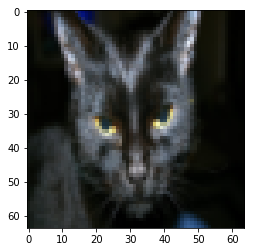

In [5]:
index = 25
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[:, index]) + ", it's a \"" + classes[0, np.squeeze(train_y[:, index])].decode("utf-8") + "\" picture.")

In [6]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
numpx = train_x_orig.shape[1]
print("number of training examples: " + str(m_train))
print("number of testing examples: " + str(m_test))
print("height/width image: " + str(numpx)) 

number of training examples: 209
number of testing examples: 50
height/width image: 64


# Flatten Image

In [7]:
train_x_flatten = train_x_orig.reshape(m_train,-1).T
test_x_flatten = test_x_orig.reshape(m_test,-1).T

In [8]:
print("train x flattened shape: ",train_x_flatten.shape)
print("test x flattened shape: ",test_x_flatten.shape)

train x flattened shape:  (12288, 209)
test x flattened shape:  (12288, 50)


# Normalize

In [9]:
train_x = train_x_flatten/255
test_x = test_x_flatten/255

# Helper Functions

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Main Program
1. inititalize parameters
2. forward and backward pass (cost function and gradient calculation)
3. optimization (gradient descent)
4. predict function
5. merge all the functions into one function named model

In [11]:
def initializeParameters(dim):
    w = np.zeros([dim, 1])
    b = 0
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    return w,b

In [12]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    #forward propogation
    z = np.dot(w.T,X) + b
    A = sigmoid(z)
    J = (-1/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))

    #backward propogation
    dz = A - Y
    dw = (1/m) * np.dot(X,dz.T)
    db = (1/m) * np.sum(dz)
    
    #sanity check
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    J = np.squeeze(J)
    assert(J.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, J

In [13]:
def optimize(w, b, X, Y, num_iter, alpha, print_cost = False):
    costs = []
    for i in range (num_iter):
        grads, J = propagate(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        
        #gradient descent
        w -= (alpha * dw)
        b -= (alpha * db)
        
        if(i%100 == 0):
            costs.append(J)
        if(print_cost and i%100 == 0):
             print ("Cost after iteration %i: %f" %(i, J))
        
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
def predict(w, b, X):
    assert(w.shape == (X.shape[0],1))
    z = np.dot(w.T,X) + b
    A = sigmoid(z)
    Y_predictions = np.zeros([1,X.shape[1]])
    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_predictions[0,i] = 1
        else:
            Y_predictions[0,i] = 0
            
    assert(Y_predictions.shape == (1, X.shape[1]))
    
    return Y_predictions

In [15]:
def model(X_train, Y_train, X_test, Y_test, num_iter, alpha, print_cost = False):
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    #initialize weights and bias
    w,b = initializeParameters(n)
    
    #gradient descent
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iter, alpha, print_cost)
    
    #final parameters
    w = params["w"]
    b = params["b"]
    
    #prediction
    Y_predictions_train = predict(w, b, X_train) 
    Y_predictions_test = predict(w, b, X_test)
    
     # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_predictions_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_predictions_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_predictions_test": Y_predictions_test, 
         "Y_predictions_train" : Y_predictions_train, 
         "w" : w, 
         "b" : b,
         "alpha" : alpha,
         "num_iter": num_iter}
    
    return d

In [16]:
d = model(train_x, train_y, test_x, test_y, num_iter = 2000, alpha = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y actual = 1
y prediction = 1
model's prediction = cat


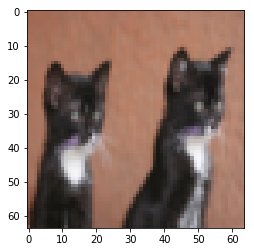

y actual = 1
y prediction = 1
model's prediction = cat


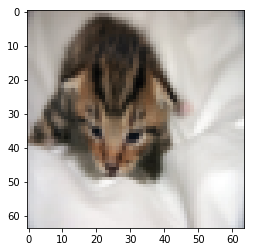

y actual = 1
y prediction = 1
model's prediction = cat


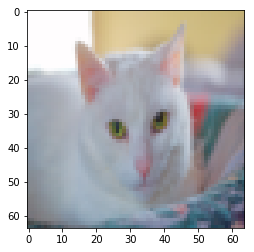

y actual = 1
y prediction = 1
model's prediction = cat


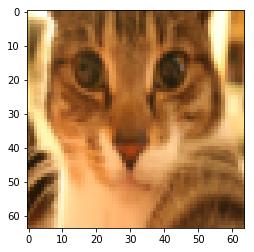

y actual = 1
y prediction = 1
model's prediction = cat


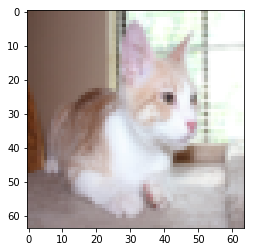

y actual = 0
y prediction = 1
model's prediction = cat


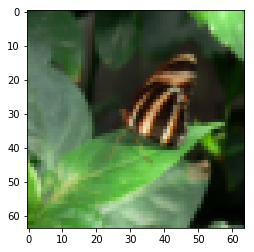

y actual = 1
y prediction = 0
model's prediction = non-cat


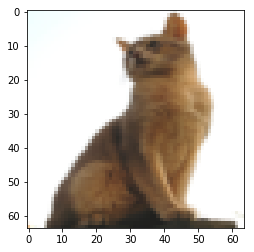

y actual = 1
y prediction = 1
model's prediction = cat


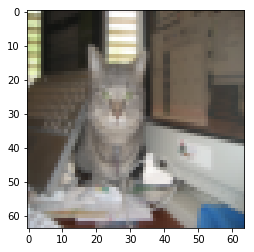

y actual = 1
y prediction = 1
model's prediction = cat


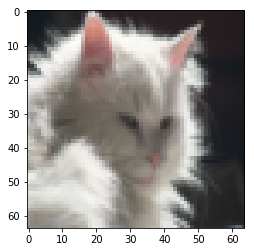

y actual = 1
y prediction = 1
model's prediction = cat


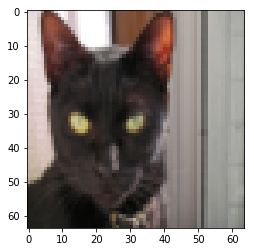

y actual = 1
y prediction = 0
model's prediction = non-cat


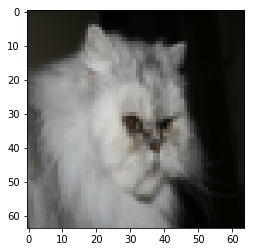

y actual = 1
y prediction = 0
model's prediction = non-cat


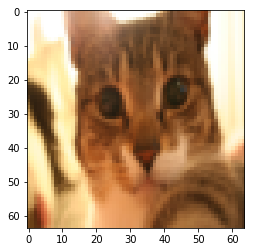

y actual = 1
y prediction = 1
model's prediction = cat


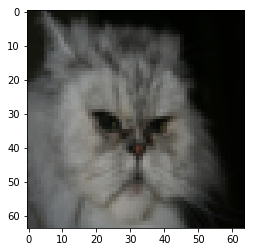

y actual = 0
y prediction = 1
model's prediction = cat


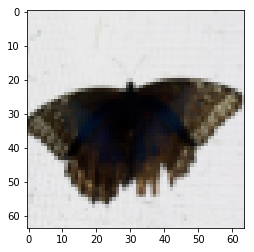

y actual = 0
y prediction = 0
model's prediction = non-cat


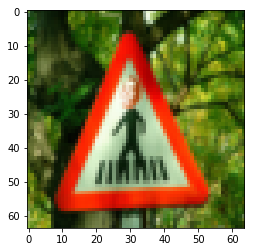

y actual = 1
y prediction = 1
model's prediction = cat


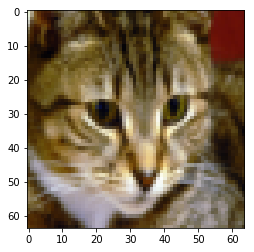

y actual = 0
y prediction = 0
model's prediction = non-cat


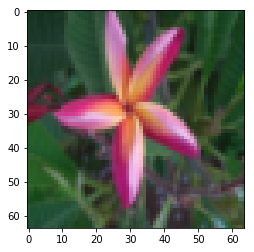

y actual = 1
y prediction = 1
model's prediction = cat


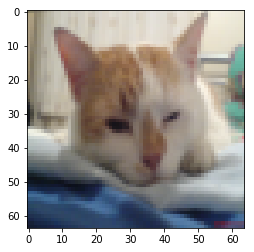

y actual = 1
y prediction = 0
model's prediction = non-cat


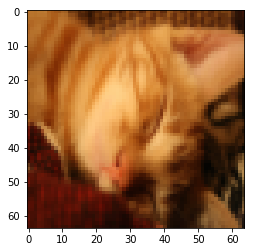

y actual = 1
y prediction = 0
model's prediction = non-cat


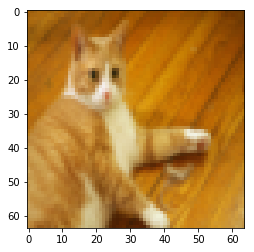

y actual = 1
y prediction = 1
model's prediction = cat


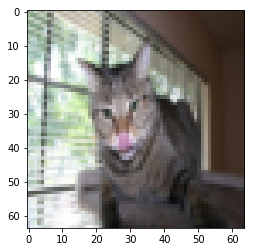

y actual = 0
y prediction = 0
model's prediction = non-cat


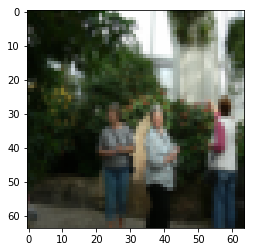

y actual = 0
y prediction = 0
model's prediction = non-cat


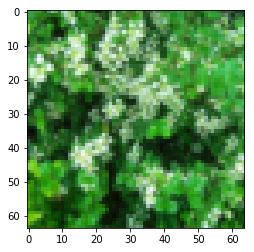

y actual = 1
y prediction = 1
model's prediction = cat


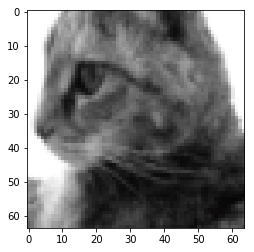

y actual = 1
y prediction = 1
model's prediction = cat


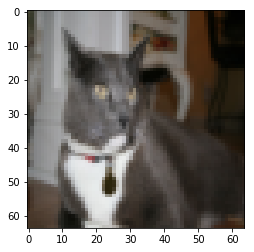

y actual = 1
y prediction = 1
model's prediction = cat


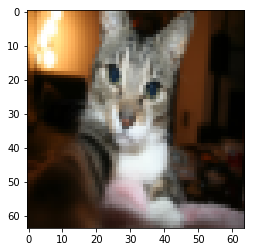

y actual = 1
y prediction = 1
model's prediction = cat


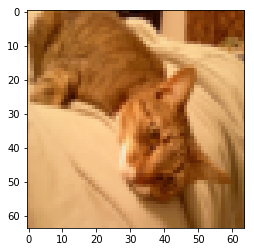

y actual = 0
y prediction = 0
model's prediction = non-cat


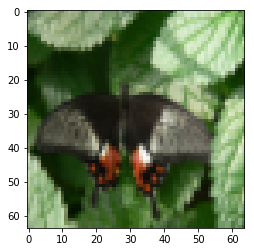

y actual = 1
y prediction = 0
model's prediction = non-cat


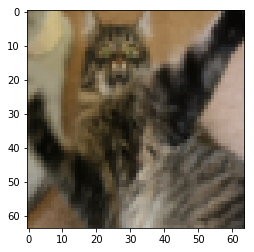

y actual = 0
y prediction = 1
model's prediction = cat


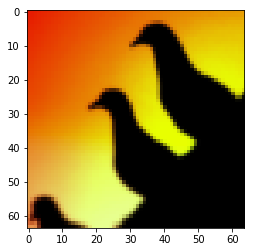

y actual = 1
y prediction = 0
model's prediction = non-cat


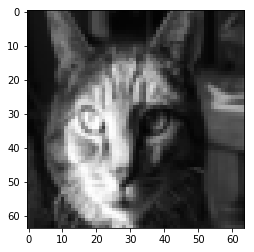

y actual = 1
y prediction = 1
model's prediction = cat


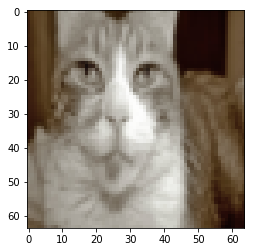

y actual = 1
y prediction = 1
model's prediction = cat


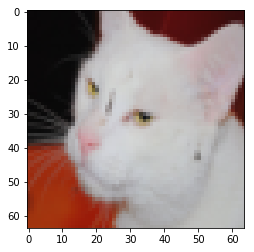

y actual = 1
y prediction = 0
model's prediction = non-cat


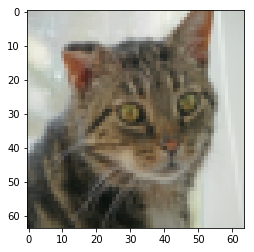

y actual = 0
y prediction = 1
model's prediction = cat


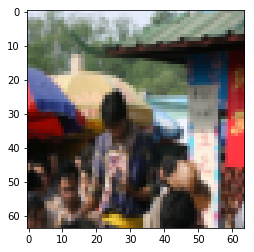

y actual = 0
y prediction = 0
model's prediction = non-cat


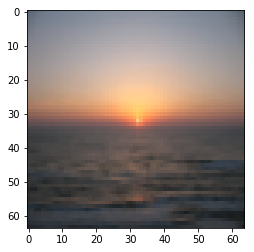

y actual = 0
y prediction = 0
model's prediction = non-cat


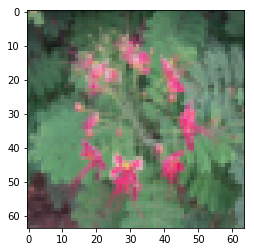

y actual = 1
y prediction = 1
model's prediction = cat


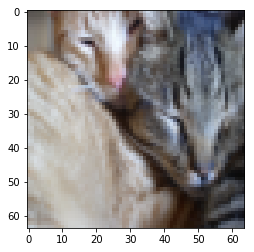

y actual = 0
y prediction = 0
model's prediction = non-cat


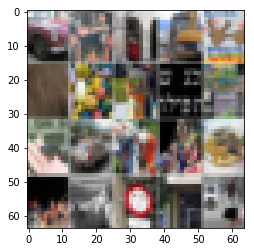

y actual = 0
y prediction = 0
model's prediction = non-cat


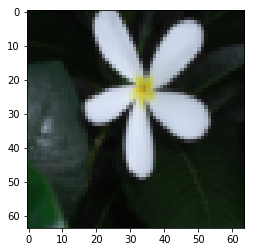

y actual = 1
y prediction = 1
model's prediction = cat


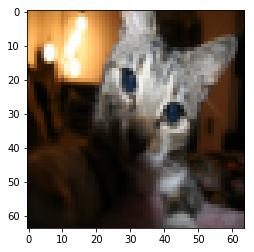

y actual = 1
y prediction = 0
model's prediction = non-cat


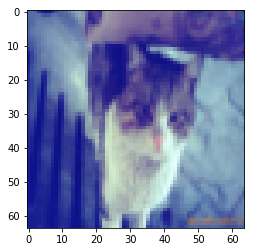

y actual = 1
y prediction = 1
model's prediction = cat


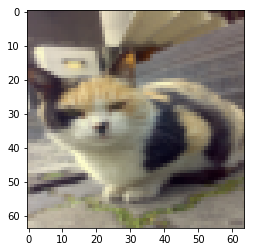

y actual = 0
y prediction = 0
model's prediction = non-cat


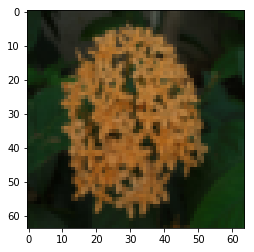

y actual = 0
y prediction = 1
model's prediction = cat


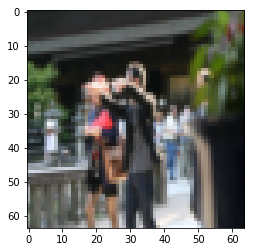

y actual = 0
y prediction = 0
model's prediction = non-cat


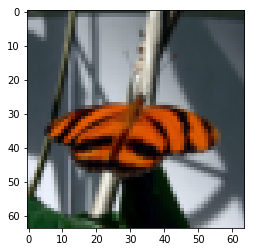

y actual = 1
y prediction = 0
model's prediction = non-cat


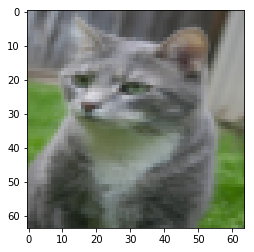

y actual = 1
y prediction = 1
model's prediction = cat


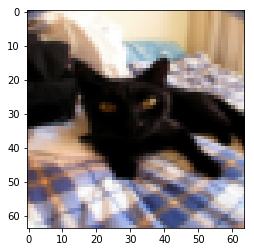

y actual = 1
y prediction = 1
model's prediction = cat


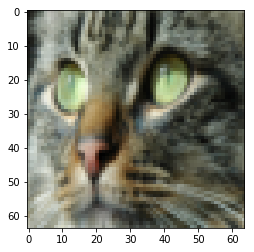

y actual = 0
y prediction = 0
model's prediction = non-cat


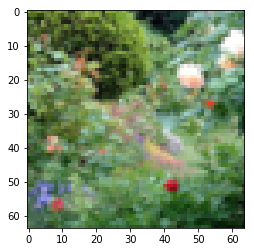

In [17]:
# Example of a picture that was wrongly classified.
plt.ion() 
for index in range(0,50):
    plt.imshow(test_x[:,index].reshape((numpx, numpx, 3)))
    print ("y actual = " + str(test_y[0,index]))
    print ("y prediction = " + str(int(d['Y_predictions_test'][0,index])))
    print ("model's prediction = " + str(classes[0, int(d['Y_predictions_test'][0,index])].decode("utf-8")))
    plt.show()

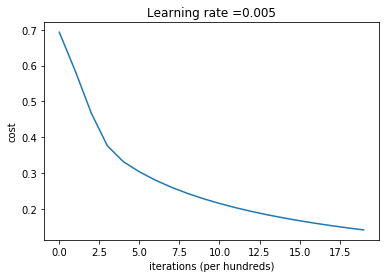

In [18]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["alpha"]))
plt.show()

y = 1.0, algorithm predicts a "cat" picture.


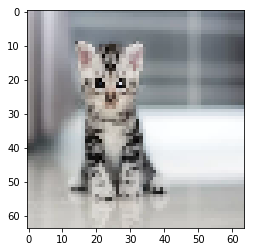

In [135]:
my_image = "cat1.jpeg" 

fname = "images/" + my_image
image = Image.open(fname).resize((numpx,numpx))
my_image = np.array(image).reshape((1, numpx*numpx*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", algorithm predicts a \"" + classes[0,int(np.squeeze(my_predicted_image))].decode("utf-8") +  "\" picture.")

(12288, 1)
<class 'numpy.ndarray'>


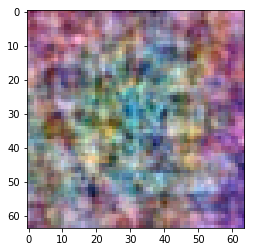

In [112]:
#feature graph
w = d["w"]
print(w.shape)
print(type(w))
w = 255 * (w - np.min(w))/(np.max(w) - np.min(w))
w = np.ceil(w).astype(int).reshape(64,64,3)
plt.imshow(w)